# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
# data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
data_dir = './input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

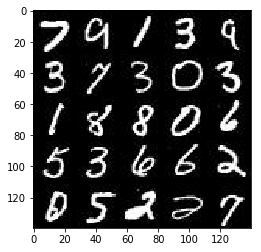

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

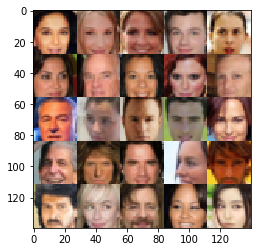

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    input_real = tf.placeholder(tf.float32, [None, image_width, image_height, image_channels], 'input_real')
    input_z = tf.placeholder(tf.float32, [None, z_dim], 'input_z')
    learning_rate = tf.placeholder(tf.float32, None, name='learning_rate')

    return (input_real, input_z, learning_rate)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    with tf.variable_scope('discriminator', reuse=reuse):
        alpha = 0.2

        x1 = tf.layers.conv2d(images, 64, 5, strides=2, kernel_initializer=tf.contrib.layers.xavier_initializer(), padding='same')
        bn1 = tf.layers.batch_normalization(x1, training=True)
        drop1 = tf.layers.dropout(bn1, 0.5)
        relu1 = tf.maximum(alpha * drop1, drop1)
        
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, kernel_initializer=tf.contrib.layers.xavier_initializer(), padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        drop2 = tf.layers.dropout(bn2, 0.5)
        relu2 = tf.maximum(alpha * drop2, drop2)
        
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, kernel_initializer=tf.contrib.layers.xavier_initializer(), padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        drop3 = tf.layers.dropout(bn3, 0.5)
        relu3 = tf.maximum(alpha * drop3, drop3)

        flat = tf.reshape(relu3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        logits = tf.layers.dropout(logits, 0.8)
        out = tf.sigmoid(logits)
        
        return out, logits

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    with tf.variable_scope('generator', reuse=(not is_train)):
        alpha = 0.2
        
        x1 = tf.layers.dense(z, 7*7*256)
        x1 = tf.reshape(x1, (-1, 7, 7, 256))
        bn1 = tf.layers.batch_normalization(x1, training=is_train)
        drop1 = tf.layers.dropout(bn1, 0.5)
        relu1 = tf.maximum(alpha * x1, x1)
        
        x2 = tf.layers.conv2d_transpose(relu1, 128, 5, strides=2, kernel_initializer=tf.contrib.layers.xavier_initializer(), padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=is_train)
        drop2 = tf.layers.dropout(bn2, 0.5)
        relu2 = tf.maximum(alpha * drop2, drop2)
        
        x3 = tf.layers.conv2d_transpose(relu2, 64, 5, strides=2, kernel_initializer=tf.contrib.layers.xavier_initializer(), padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=is_train)
        drop3 = tf.layers.dropout(bn3, 0.5)
        relu3 = tf.maximum(alpha * drop3, drop3)
        
        logits = tf.layers.conv2d_transpose(relu3, out_channel_dim, 3, strides=1, kernel_initializer=tf.contrib.layers.xavier_initializer(), padding='same')
        logits = tf.layers.dropout(logits, 0.8)
        out = tf.tanh(logits)
        
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""

tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [ ]:
from sklearn import preprocessing

def minmax_scale(x):
    scaled_x = np.zeros_like(x)
    
    for i, image_set in enumerate(x):
        for j, image in enumerate(image_set):
            min_max_scaler = preprocessing.MinMaxScaler((-1, 1))
            scaled_x[i][j] = min_max_scaler.fit_transform(image)
            scaled_x[i][j]

    return scaled_x

def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    input_real, input_z, lr = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, lr, beta1) 
    
    steps = 0
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):    
                steps += 1
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                batch_images = minmax_scale(batch_images)
                
                _ = sess.run(
                        d_train_opt,
                        feed_dict={
                            input_real: batch_images,
                            input_z: batch_z,
                            lr: learning_rate
                        }
                )
                _ = sess.run(
                        g_train_opt,
                        feed_dict={
                            input_z: batch_z,
                            input_real: batch_images,
                            lr: learning_rate
                        }
                )

                if steps % 25 == 0:      
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print(
                        "Epoch {}/{}...".format(epoch_i+1, epoch_count),
                        "Step {}...".format(steps),
                        "Discriminator Loss: {:.4f}...".format(train_loss_d),
                        "Generator Loss: {:.4f}".format(train_loss_g)
                    )
                    
                if steps % 100 == 0:
                    show_generator_output(sess, 25, input_z, data_shape[3], data_image_mode)                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Step 25... Discriminator Loss: 2.7435... Generator Loss: 0.1326
Epoch 1/2... Step 50... Discriminator Loss: 1.1454... Generator Loss: 1.4253
Epoch 1/2... Step 75... Discriminator Loss: 1.1908... Generator Loss: 0.6867
Epoch 1/2... Step 100... Discriminator Loss: 1.1410... Generator Loss: 0.6548


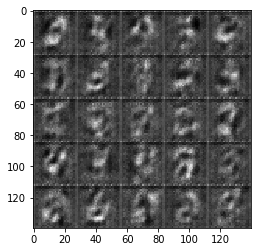

Epoch 1/2... Step 125... Discriminator Loss: 1.3148... Generator Loss: 1.1934
Epoch 1/2... Step 150... Discriminator Loss: 1.0599... Generator Loss: 0.6818
Epoch 1/2... Step 175... Discriminator Loss: 0.5011... Generator Loss: 1.5536
Epoch 1/2... Step 200... Discriminator Loss: 0.5119... Generator Loss: 1.7733


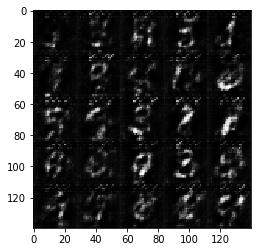

Epoch 1/2... Step 225... Discriminator Loss: 0.3608... Generator Loss: 1.7540
Epoch 1/2... Step 250... Discriminator Loss: 0.9099... Generator Loss: 0.8345
Epoch 1/2... Step 275... Discriminator Loss: 0.5926... Generator Loss: 1.2818
Epoch 1/2... Step 300... Discriminator Loss: 0.2405... Generator Loss: 2.4951


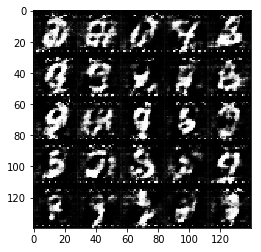

Epoch 1/2... Step 325... Discriminator Loss: 1.4420... Generator Loss: 0.3904
Epoch 1/2... Step 350... Discriminator Loss: 0.3677... Generator Loss: 2.7132
Epoch 1/2... Step 375... Discriminator Loss: 0.2626... Generator Loss: 3.0237
Epoch 1/2... Step 400... Discriminator Loss: 0.3475... Generator Loss: 1.9317


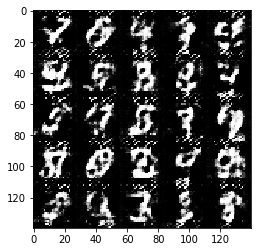

Epoch 1/2... Step 425... Discriminator Loss: 0.4669... Generator Loss: 1.5235
Epoch 1/2... Step 450... Discriminator Loss: 0.6212... Generator Loss: 1.1216
Epoch 1/2... Step 475... Discriminator Loss: 0.6492... Generator Loss: 1.5278
Epoch 1/2... Step 500... Discriminator Loss: 0.3171... Generator Loss: 2.5355


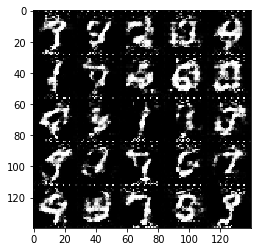

Epoch 1/2... Step 525... Discriminator Loss: 0.8045... Generator Loss: 1.6394
Epoch 1/2... Step 550... Discriminator Loss: 0.7662... Generator Loss: 0.9392
Epoch 1/2... Step 575... Discriminator Loss: 0.8125... Generator Loss: 0.9542
Epoch 1/2... Step 600... Discriminator Loss: 0.4969... Generator Loss: 1.4884


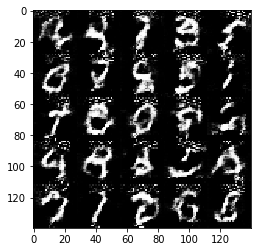

Epoch 1/2... Step 625... Discriminator Loss: 0.7552... Generator Loss: 1.9334
Epoch 1/2... Step 650... Discriminator Loss: 0.8574... Generator Loss: 0.7742
Epoch 2/2... Step 975... Discriminator Loss: 1.0391... Generator Loss: 0.6435
Epoch 2/2... Step 1000... Discriminator Loss: 0.7844... Generator Loss: 0.9573


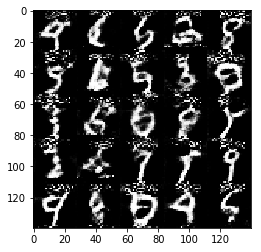

Epoch 2/2... Step 1025... Discriminator Loss: 0.7237... Generator Loss: 1.5273
Epoch 2/2... Step 1050... Discriminator Loss: 1.9636... Generator Loss: 0.2681
Epoch 2/2... Step 1075... Discriminator Loss: 0.5895... Generator Loss: 1.3965
Epoch 2/2... Step 1100... Discriminator Loss: 0.6797... Generator Loss: 1.3295


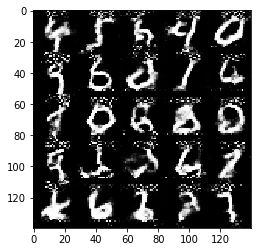

Epoch 2/2... Step 1125... Discriminator Loss: 0.6669... Generator Loss: 1.6622
Epoch 2/2... Step 1150... Discriminator Loss: 0.6687... Generator Loss: 1.5139
Epoch 2/2... Step 1175... Discriminator Loss: 0.5290... Generator Loss: 1.5212
Epoch 2/2... Step 1200... Discriminator Loss: 0.5978... Generator Loss: 1.6989


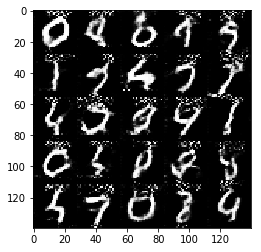

Epoch 2/2... Step 1225... Discriminator Loss: 0.5557... Generator Loss: 1.5218
Epoch 2/2... Step 1250... Discriminator Loss: 0.6270... Generator Loss: 1.1967
Epoch 2/2... Step 1275... Discriminator Loss: 0.6348... Generator Loss: 1.6483
Epoch 2/2... Step 1300... Discriminator Loss: 1.3536... Generator Loss: 0.3926


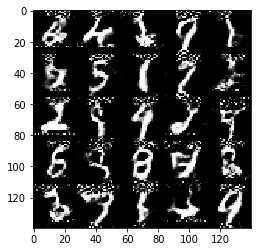

Epoch 2/2... Step 1325... Discriminator Loss: 0.7498... Generator Loss: 2.0355
Epoch 2/2... Step 1350... Discriminator Loss: 0.8356... Generator Loss: 0.8638
Epoch 2/2... Step 1375... Discriminator Loss: 0.5886... Generator Loss: 1.1635
Epoch 2/2... Step 1400... Discriminator Loss: 0.5979... Generator Loss: 1.4142


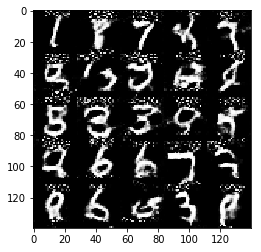

Epoch 2/2... Step 1425... Discriminator Loss: 0.4709... Generator Loss: 2.2254
Epoch 2/2... Step 1450... Discriminator Loss: 1.8522... Generator Loss: 0.2592
Epoch 2/2... Step 1475... Discriminator Loss: 0.7542... Generator Loss: 0.9148
Epoch 2/2... Step 1500... Discriminator Loss: 0.5851... Generator Loss: 1.9808


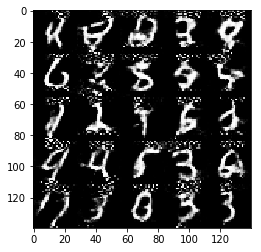

Epoch 2/2... Step 1525... Discriminator Loss: 0.7617... Generator Loss: 0.8486
Epoch 2/2... Step 1550... Discriminator Loss: 0.6359... Generator Loss: 1.0780
Epoch 2/2... Step 1575... Discriminator Loss: 0.7107... Generator Loss: 0.9950
Epoch 2/2... Step 1600... Discriminator Loss: 0.5671... Generator Loss: 1.9386


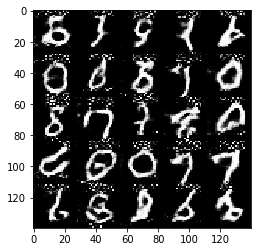

Epoch 2/2... Step 1625... Discriminator Loss: 0.9656... Generator Loss: 0.8708
Epoch 2/2... Step 1650... Discriminator Loss: 0.8898... Generator Loss: 0.7212
Epoch 2/2... Step 1675... Discriminator Loss: 0.6071... Generator Loss: 1.7799
Epoch 2/2... Step 1700... Discriminator Loss: 0.6196... Generator Loss: 1.0571


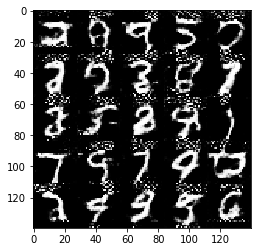

Epoch 2/2... Step 1725... Discriminator Loss: 0.7466... Generator Loss: 1.0343
Epoch 2/2... Step 1750... Discriminator Loss: 0.7267... Generator Loss: 1.2195
Epoch 2/2... Step 1775... Discriminator Loss: 0.8057... Generator Loss: 0.9389
Epoch 2/2... Step 1800... Discriminator Loss: 0.6059... Generator Loss: 1.3534


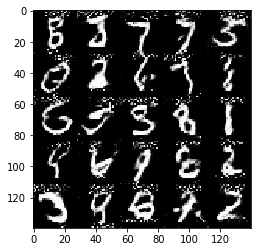

Epoch 2/2... Step 1825... Discriminator Loss: 0.8875... Generator Loss: 0.7555
Epoch 2/2... Step 1850... Discriminator Loss: 0.6504... Generator Loss: 1.5725


In [ ]:
batch_size = 64
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Step 25... Discriminator Loss: 0.3647... Generator Loss: 1.7178
Epoch 1/1... Step 50... Discriminator Loss: 0.1532... Generator Loss: 9.3427
Epoch 1/1... Step 75... Discriminator Loss: 0.9509... Generator Loss: 1.0686
Epoch 1/1... Step 100... Discriminator Loss: 1.2009... Generator Loss: 0.6696


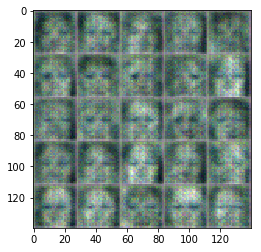

Epoch 1/1... Step 125... Discriminator Loss: 0.9148... Generator Loss: 1.4340
Epoch 1/1... Step 150... Discriminator Loss: 1.4073... Generator Loss: 0.4583
Epoch 1/1... Step 175... Discriminator Loss: 0.9801... Generator Loss: 1.5900
Epoch 1/1... Step 200... Discriminator Loss: 0.8916... Generator Loss: 1.8905


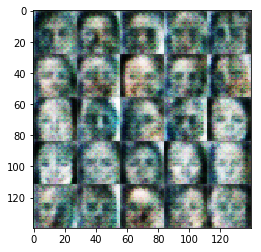

Epoch 1/1... Step 225... Discriminator Loss: 0.9331... Generator Loss: 1.6682
Epoch 1/1... Step 250... Discriminator Loss: 1.2449... Generator Loss: 0.5353
Epoch 1/1... Step 275... Discriminator Loss: 0.7843... Generator Loss: 1.2650
Epoch 1/1... Step 300... Discriminator Loss: 0.8560... Generator Loss: 0.9304


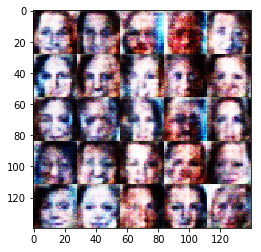

Epoch 1/1... Step 325... Discriminator Loss: 0.9861... Generator Loss: 0.7100
Epoch 1/1... Step 350... Discriminator Loss: 0.7647... Generator Loss: 1.1587
Epoch 1/1... Step 375... Discriminator Loss: 1.3112... Generator Loss: 0.9326
Epoch 1/1... Step 400... Discriminator Loss: 1.4398... Generator Loss: 1.5092


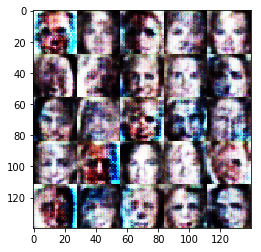

Epoch 1/1... Step 425... Discriminator Loss: 1.3626... Generator Loss: 0.5952
Epoch 1/1... Step 450... Discriminator Loss: 0.9509... Generator Loss: 1.4282
Epoch 1/1... Step 475... Discriminator Loss: 0.9663... Generator Loss: 1.1718
Epoch 1/1... Step 500... Discriminator Loss: 1.1522... Generator Loss: 1.0751


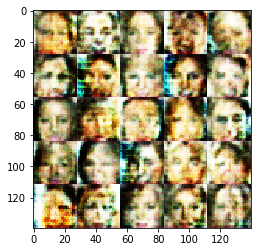

Epoch 1/1... Step 525... Discriminator Loss: 0.9085... Generator Loss: 0.9459
Epoch 1/1... Step 550... Discriminator Loss: 0.8675... Generator Loss: 1.1069
Epoch 1/1... Step 575... Discriminator Loss: 1.0286... Generator Loss: 0.6516
Epoch 1/1... Step 600... Discriminator Loss: 0.9118... Generator Loss: 1.0172


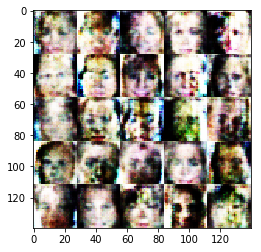

Epoch 1/1... Step 625... Discriminator Loss: 0.9718... Generator Loss: 0.8684
Epoch 1/1... Step 650... Discriminator Loss: 0.8753... Generator Loss: 0.8648
Epoch 1/1... Step 675... Discriminator Loss: 0.9751... Generator Loss: 0.8354
Epoch 1/1... Step 700... Discriminator Loss: 1.2580... Generator Loss: 0.5034


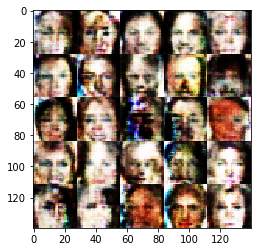

Epoch 1/1... Step 725... Discriminator Loss: 0.8951... Generator Loss: 0.8137
Epoch 1/1... Step 750... Discriminator Loss: 0.9360... Generator Loss: 0.8766
Epoch 1/1... Step 775... Discriminator Loss: 0.8918... Generator Loss: 0.8304
Epoch 1/1... Step 800... Discriminator Loss: 0.7500... Generator Loss: 1.0608


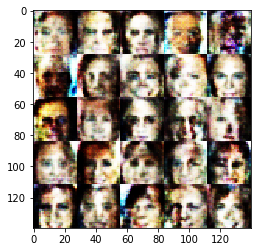

Epoch 1/1... Step 825... Discriminator Loss: 0.9101... Generator Loss: 1.1509
Epoch 1/1... Step 850... Discriminator Loss: 1.1910... Generator Loss: 0.6153
Epoch 1/1... Step 875... Discriminator Loss: 0.9290... Generator Loss: 0.9544
Epoch 1/1... Step 900... Discriminator Loss: 0.7965... Generator Loss: 1.7263


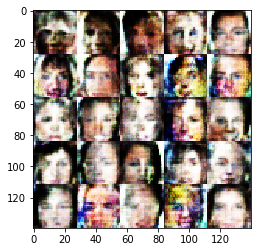

Epoch 1/1... Step 925... Discriminator Loss: 1.1215... Generator Loss: 0.7930
Epoch 1/1... Step 950... Discriminator Loss: 1.3577... Generator Loss: 0.4692
Epoch 1/1... Step 975... Discriminator Loss: 1.2730... Generator Loss: 0.4898
Epoch 1/1... Step 1000... Discriminator Loss: 1.2040... Generator Loss: 0.6632


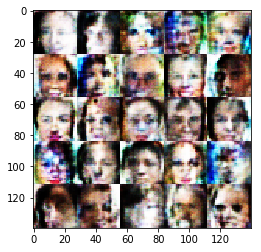

Epoch 1/1... Step 1025... Discriminator Loss: 1.0519... Generator Loss: 1.1578
Epoch 1/1... Step 1050... Discriminator Loss: 1.0661... Generator Loss: 0.7551
Epoch 1/1... Step 1075... Discriminator Loss: 1.1380... Generator Loss: 0.5775
Epoch 1/1... Step 1100... Discriminator Loss: 1.1654... Generator Loss: 0.6496


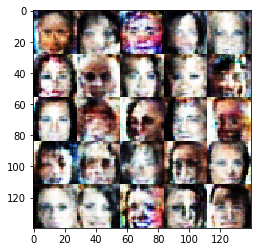

Epoch 1/1... Step 1125... Discriminator Loss: 1.0945... Generator Loss: 0.7129
Epoch 1/1... Step 1150... Discriminator Loss: 1.2399... Generator Loss: 0.5176
Epoch 1/1... Step 1175... Discriminator Loss: 1.1670... Generator Loss: 0.7548
Epoch 1/1... Step 1200... Discriminator Loss: 1.0469... Generator Loss: 0.6910


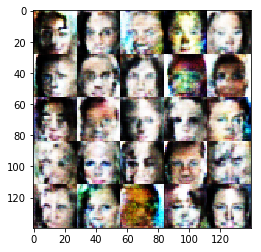

Epoch 1/1... Step 1225... Discriminator Loss: 1.1123... Generator Loss: 0.7594
Epoch 1/1... Step 1250... Discriminator Loss: 0.9724... Generator Loss: 0.9584
Epoch 1/1... Step 1275... Discriminator Loss: 1.2947... Generator Loss: 0.7384
Epoch 1/1... Step 1300... Discriminator Loss: 0.9503... Generator Loss: 0.8461


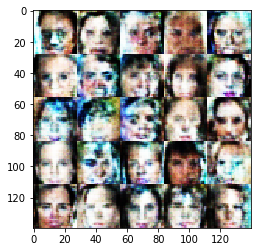

Epoch 1/1... Step 1325... Discriminator Loss: 1.0318... Generator Loss: 1.5586
Epoch 1/1... Step 1350... Discriminator Loss: 1.0732... Generator Loss: 0.6659
Epoch 1/1... Step 1375... Discriminator Loss: 1.3396... Generator Loss: 0.4323
Epoch 1/1... Step 1400... Discriminator Loss: 1.0464... Generator Loss: 0.8513


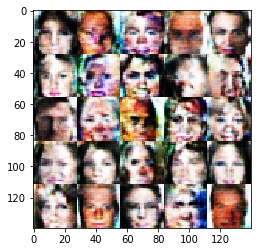

Epoch 1/1... Step 1425... Discriminator Loss: 1.0988... Generator Loss: 0.6448
Epoch 1/1... Step 1450... Discriminator Loss: 1.1424... Generator Loss: 0.6336
Epoch 1/1... Step 1475... Discriminator Loss: 1.2966... Generator Loss: 1.0536
Epoch 1/1... Step 1500... Discriminator Loss: 0.8600... Generator Loss: 0.9406


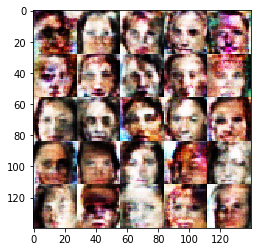

Epoch 1/1... Step 1525... Discriminator Loss: 1.1785... Generator Loss: 0.6732
Epoch 1/1... Step 1550... Discriminator Loss: 1.1921... Generator Loss: 0.5517
Epoch 1/1... Step 1575... Discriminator Loss: 1.0938... Generator Loss: 1.0284
Epoch 1/1... Step 1600... Discriminator Loss: 1.0269... Generator Loss: 1.1123


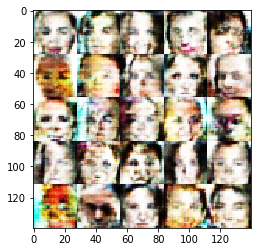

Epoch 1/1... Step 1625... Discriminator Loss: 1.0482... Generator Loss: 0.7759
Epoch 1/1... Step 1650... Discriminator Loss: 0.9337... Generator Loss: 1.1677
Epoch 1/1... Step 1675... Discriminator Loss: 1.1131... Generator Loss: 0.7003
Epoch 1/1... Step 1700... Discriminator Loss: 1.2941... Generator Loss: 0.8438


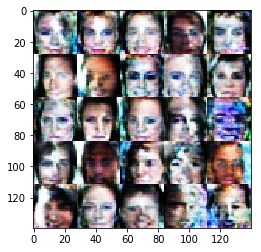

Epoch 1/1... Step 1725... Discriminator Loss: 1.0171... Generator Loss: 0.8111
Epoch 1/1... Step 1750... Discriminator Loss: 1.0800... Generator Loss: 1.0370
Epoch 1/1... Step 1775... Discriminator Loss: 0.9977... Generator Loss: 0.9779
Epoch 1/1... Step 1800... Discriminator Loss: 0.8809... Generator Loss: 1.3345


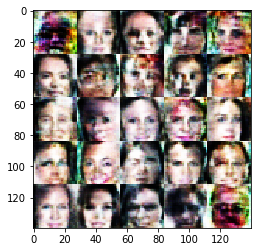

Epoch 1/1... Step 1825... Discriminator Loss: 1.2249... Generator Loss: 0.6518
Epoch 1/1... Step 1850... Discriminator Loss: 1.0573... Generator Loss: 0.9825
Epoch 1/1... Step 1875... Discriminator Loss: 1.0607... Generator Loss: 0.6506
Epoch 1/1... Step 1900... Discriminator Loss: 1.1856... Generator Loss: 0.6918


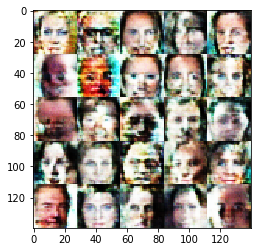

Epoch 1/1... Step 1925... Discriminator Loss: 1.1989... Generator Loss: 1.5583
Epoch 1/1... Step 1950... Discriminator Loss: 1.0856... Generator Loss: 0.8540
Epoch 1/1... Step 1975... Discriminator Loss: 1.0510... Generator Loss: 0.8215
Epoch 1/1... Step 2000... Discriminator Loss: 1.1854... Generator Loss: 0.6457


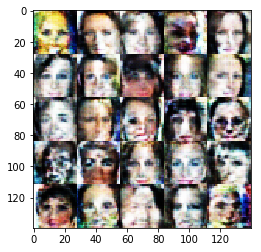

Epoch 1/1... Step 2025... Discriminator Loss: 1.0998... Generator Loss: 0.7719
Epoch 1/1... Step 2050... Discriminator Loss: 0.9336... Generator Loss: 1.0282
Epoch 1/1... Step 2075... Discriminator Loss: 1.4069... Generator Loss: 0.3891
Epoch 1/1... Step 2100... Discriminator Loss: 1.0348... Generator Loss: 0.7996


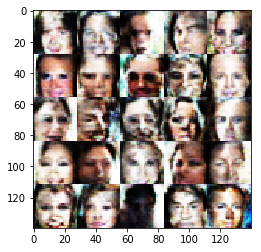

Epoch 1/1... Step 2125... Discriminator Loss: 1.0809... Generator Loss: 0.8615
Epoch 1/1... Step 2150... Discriminator Loss: 1.1110... Generator Loss: 0.6120
Epoch 1/1... Step 2175... Discriminator Loss: 0.8973... Generator Loss: 0.8978
Epoch 1/1... Step 2200... Discriminator Loss: 1.0361... Generator Loss: 0.7062


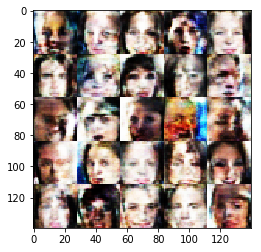

Epoch 1/1... Step 2225... Discriminator Loss: 1.0189... Generator Loss: 0.9664
Epoch 1/1... Step 2250... Discriminator Loss: 1.0688... Generator Loss: 0.7224
Epoch 1/1... Step 2275... Discriminator Loss: 1.6418... Generator Loss: 0.3139
Epoch 1/1... Step 2300... Discriminator Loss: 0.8045... Generator Loss: 0.9285


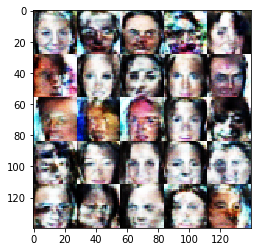

Epoch 1/1... Step 2325... Discriminator Loss: 0.7974... Generator Loss: 1.0023
Epoch 1/1... Step 2350... Discriminator Loss: 0.7703... Generator Loss: 1.0799
Epoch 1/1... Step 2375... Discriminator Loss: 0.9729... Generator Loss: 0.6775
Epoch 1/1... Step 2400... Discriminator Loss: 0.8708... Generator Loss: 0.9021


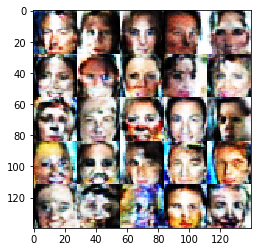

Epoch 1/1... Step 2425... Discriminator Loss: 0.9857... Generator Loss: 0.6230
Epoch 1/1... Step 2450... Discriminator Loss: 1.1653... Generator Loss: 0.5146
Epoch 1/1... Step 2475... Discriminator Loss: 0.5214... Generator Loss: 1.5949
Epoch 1/1... Step 2500... Discriminator Loss: 0.9738... Generator Loss: 1.7490


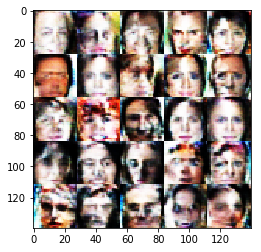

Epoch 1/1... Step 2525... Discriminator Loss: 0.9714... Generator Loss: 0.6295
Epoch 1/1... Step 2550... Discriminator Loss: 0.5005... Generator Loss: 1.8661
Epoch 1/1... Step 2575... Discriminator Loss: 0.4408... Generator Loss: 1.4874
Epoch 1/1... Step 2600... Discriminator Loss: 0.5704... Generator Loss: 1.9100


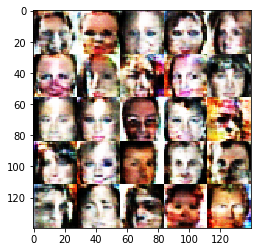

Epoch 1/1... Step 2625... Discriminator Loss: 0.7847... Generator Loss: 0.8421
Epoch 1/1... Step 2650... Discriminator Loss: 0.3697... Generator Loss: 2.9836
Epoch 1/1... Step 2675... Discriminator Loss: 0.5386... Generator Loss: 2.1725
Epoch 1/1... Step 2700... Discriminator Loss: 0.8197... Generator Loss: 0.9469


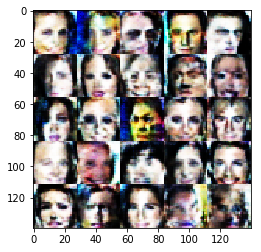

Epoch 1/1... Step 2725... Discriminator Loss: 0.8983... Generator Loss: 0.7313
Epoch 1/1... Step 2750... Discriminator Loss: 0.5417... Generator Loss: 1.3052
Epoch 1/1... Step 2775... Discriminator Loss: 0.8890... Generator Loss: 0.7169
Epoch 1/1... Step 2800... Discriminator Loss: 0.6069... Generator Loss: 1.4118


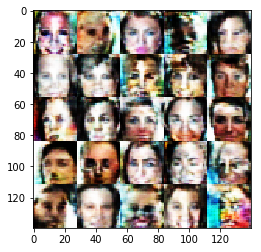

Epoch 1/1... Step 2825... Discriminator Loss: 0.6210... Generator Loss: 1.1123
Epoch 1/1... Step 2850... Discriminator Loss: 0.8289... Generator Loss: 0.8584
Epoch 1/1... Step 2875... Discriminator Loss: 0.8690... Generator Loss: 0.7686
Epoch 1/1... Step 2900... Discriminator Loss: 1.2602... Generator Loss: 0.4473


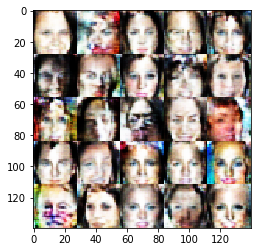

Epoch 1/1... Step 2925... Discriminator Loss: 0.6710... Generator Loss: 1.1989
Epoch 1/1... Step 2950... Discriminator Loss: 0.8836... Generator Loss: 0.7869
Epoch 1/1... Step 2975... Discriminator Loss: 1.1386... Generator Loss: 0.6076
Epoch 1/1... Step 3000... Discriminator Loss: 1.2144... Generator Loss: 0.4879


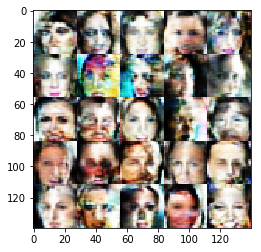

Epoch 1/1... Step 3025... Discriminator Loss: 0.7568... Generator Loss: 0.9435
Epoch 1/1... Step 3050... Discriminator Loss: 0.9264... Generator Loss: 0.8420
Epoch 1/1... Step 3075... Discriminator Loss: 1.0937... Generator Loss: 0.5995
Epoch 1/1... Step 3100... Discriminator Loss: 1.0120... Generator Loss: 0.7806


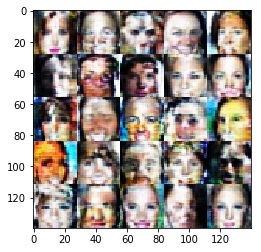

Epoch 1/1... Step 3125... Discriminator Loss: 1.4906... Generator Loss: 0.3615
Epoch 1/1... Step 3150... Discriminator Loss: 0.8393... Generator Loss: 1.2273


In [ ]:
batch_size = 64
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.